In [1]:
import numpy as np

import dolfinx

from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import fem, mesh, io, plot, log,default_scalar_type
from dolfinx.fem import (Constant, dirichletbc, Function, functionspace, Expression )
from dolfinx.fem.petsc import NonlinearProblem,LinearProblem
from dolfinx.nls.petsc import NewtonSolver
from dolfinx.io import XDMFFile, VTXWriter
import ufl
from ufl import (TestFunctions, TrialFunction, Identity, grad, det, div, dev, inv, tr, sqrt, conditional , gt, dx, inner, derivative, dot, ln, split,TestFunction,indices,as_tensor)
from basix.ufl import element, mixed_element, quadrature_element
from datetime import datetime
from dolfinx.plot import vtk_mesh
from dolfinx.fem.petsc import  assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc,create_matrix, create_vector
import basix
import pyvista
pyvista.set_jupyter_backend('client')


from ElasticPlasticity.Plastic_material import Plastic_Material
from ElasticPlasticity.Plastic_Visibility import Problem_Saver
from ElasticPlasticity.Plasticity_Funcs import *
from ElasticPlasticity.Plasticity_Problem import Plastic_Problem_Def

In [2]:
problem_name = "Plastic Tensile Test"
# Geometric parameters
geom = {"longside" : 100.0,     # mm
        "side" : 10.0,      # mm
        "num_elements" : 3,    # size of a cell
        }


# Mechanicals parameters
mech = {"E" : 200e3,    # MPa
        "nu" : 0.3,     #       
        "sig0" : 100.0,  # MPa
        "H" : 0.0, # MPa
        "r" : 1.0,
        "Y_s" :100.0,#mpa
        "C" : 0.0,
        "gamma":0.0
        
        }


# Study parameters
stud = {"deg_u" : 2,    # Interpolation of u
        "deg_stress" : 2,  # Interpolation of sig, eps, p
        }

load_steps  = {
        "N_incr" : 20,  # Number of load steps
        "max_disp" : 1.0 # Maximal displacemen
        }


# Domain and Boundary Definition

In [3]:
domain = mesh.create_box(MPI.COMM_WORLD,[[0.0,0.0,0.0],[geom["longside"],geom["side"],geom["side"]]],[geom["num_elements"]*10,geom["num_elements"],geom["num_elements"]])


def xBot(x):
    return np.isclose(x[0], 0)
def xTop(x):
    return np.isclose(x[0], geom["longside"])
def yBot(x):
    return np.isclose(x[1], 0)
def yTop(x):
    return np.isclose(x[1], geom["side"])
def zBot(x):
    return np.isclose(x[2], 0)
def zTop(x):
    return np.isclose(x[2], geom["side"])

boundaries = [(1, xBot),(2,xTop),(3,yBot),(4,yTop),(5,zBot),(6,zTop)]

facet_indices, facet_markers = [], []
fdim = domain.topology.dim - 1
for (marker, locator) in boundaries:
    facets = mesh.locate_entities(domain, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))

facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = mesh.meshtags(domain, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

In [4]:
mat = Plastic_Material(domain = domain,**mech)
plastic_problem = Plastic_Problem_Def(domain,mat,facet_tags=facet_tag,**stud)

# Boundary Conditions

In [5]:
from traitlets import default
V = plastic_problem.W_space.sub(0)

left_facets = facet_tag.find(1)

right_facets = facet_tag.find(2)


top_facets = facet_tag.find(3)
side_facets = facet_tag.find(5)


fdim = domain.topology.dim - 1
domain.topology.create_connectivity(fdim, domain.topology.dim)
disp = Constant(domain,0.0)

left_dofs_x = fem.locate_dofs_topological(V, fdim, left_facets)
top_dof_y = fem.locate_dofs_topological(V.sub(1), fdim, top_facets)
top_dof_z = fem.locate_dofs_topological(V.sub(2), fdim, side_facets)
right_dofs_x = fem.locate_dofs_topological(V.sub(0),fdim, right_facets)

sym_bottom = fem.dirichletbc(0.0, left_dofs_x, V.sub(0))
sym_left = fem.dirichletbc(disp, right_dofs_x, V.sub(0))

sym_top = fem.dirichletbc(0.0, top_dof_z, V.sub(1))
sym_side = fem.dirichletbc(0.0, top_dof_y, V.sub(2))

bcs = [sym_bottom,sym_left,sym_top,sym_side]

#disp = Constant(domain,np.array(((0,0,0),(0,0,0),(0,0,0)),dtype=default_scalar_type))

def F_ext(t):
    return t*load_steps["max_disp"]

In [6]:
plastic_problem.init_nonlinear_problem()
plastic_problem.init_non_linear_solver(bcs)

ValueError: Shape mismatch between conditional branches.

# Data for Plotting

In [ ]:
E_n = eps(plastic_problem.u)
E_p = plastic_problem.E_p

Stress_Point = mat.sigma(E_n - E_p)
area= Constant(domain,(geom["side"]*geom["side"]))
Elastic = Function(functionspace(domain,("Lagrange",2)))

project(Stress_Point[0,0],Elastic)
engineeringStress= fem.form(Elastic/area*plastic_problem.ds(2)) #P22/area*ds


pointForStress = [geom["longside"],5,5]

bb_tree = dolfinx.geometry.bb_tree(domain,domain.topology.dim)
cell_candidates = dolfinx.geometry.compute_collisions_points(bb_tree, np.array(pointForStress))
colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates,  np.array(pointForStress))

In [ ]:
#saver = Problem_Saver(plastic_problem,problem_name)


# Problem Solving

In [ ]:
startTime = datetime.now()
Nincr = load_steps["N_incr"]

time_steps = np.linspace(0, 1, Nincr+1)[1:]
results = np.zeros((Nincr+1, 3))


print("------------------------------------")
print("Simulation Start")
print("------------------------------------")

log.set_log_level(log.LogLevel.INFO)
#saver.update_and_save(0)
for (i, t) in enumerate(time_steps):
    # Update Diriclet boundary condition
   
    disp.value = F_ext(t)
    # Update the right hand side reusing the initial vector

    print("Increment:", str(i+1))
    niter = 0

    print("Starting Plastic Step")
    plastic_problem.solve_nls()
    
    print("Stop Plastic Step  Done")
    # print("Linear Step 2 Start")
    #plastic_problem.solve_linear(bcs) #Solves for the actual displacement after the plastic update
    # print("Linear Step 2 Done")
    
    #vec1 = fem.assemble_vector(fem.form(plastic_problem.res_p))
    #print(plastic_problem.du.x.array)
    
    
    
    project(normVM(Stress_Point),Elastic)
    u_pointe = plastic_problem.u.eval(pointForStress,colliding_cells.array[0])[0]
    stress =domain.comm.gather(fem.assemble_scalar(engineeringStress))[0]
    vec2 = fem.assemble_vector(fem.form(plastic_problem.Res))
    #print(vec1.norm())
    print(vec2.norm())
    results[i + 1, :] = (u_pointe,stress,t)
    
    #saver.update_and_save(t)
    

print("-----------------------------------------")
print("End computation")                 
# Report elapsed real time for the analysis
endTime = datetime.now()
elapseTime = endTime - startTime
print("------------------------------------------")
print("Elapsed real time:  {}".format(elapseTime))
print("------------------------------------------")    
#saver.close()

------------------------------------
Simulation Start
------------------------------------
Increment: 1
Starting Plastic Step


2023-12-11 05:11:33.073 (   2.476s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-11 05:11:34.360 (   3.764s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-11 05:11:35.209 (   4.613s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 8.91571e-13 (tol = 1e-08) r (rel) = 1.10756e-16(tol = 1e-08)
2023-12-11 05:11:35.209 (   4.613s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.
2023-12-11 05:11:35.217 (   4.621s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0


Residual: 2598.9886433986085
Stop Plastic Step  Done
2598.9886433986085
Increment: 2
Starting Plastic Step


2023-12-11 05:11:35.425 (   4.829s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-11 05:11:36.459 (   5.863s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.
2023-12-11 05:11:37.309 (   6.709s) [main            ]       NewtonSolver.cpp:36    INFO| Newton iteration 2: r (abs) = 5.43276e-15 (tol = 1e-08) r (rel) = 3.43556e-15(tol = 1e-08)
2023-12-11 05:11:37.309 (   6.709s) [main            ]       NewtonSolver.cpp:250   INFO| Newton solver finished in 2 iterations and 2 linear solver iterations.


Residual: 5197.9772867972215
Stop Plastic Step  Done
5197.9772867972215
Increment: 3
Starting Plastic Step


2023-12-11 05:11:37.317 (   6.718s) [main            ]    SparsityPattern.cpp:384   INFO| Column ghost size increased from 0 to 0
2023-12-11 05:11:37.525 (   6.926s) [main            ]              petsc.cpp:698   INFO| PETSc Krylov solver starting to solve system.


KeyboardInterrupt: 

: 

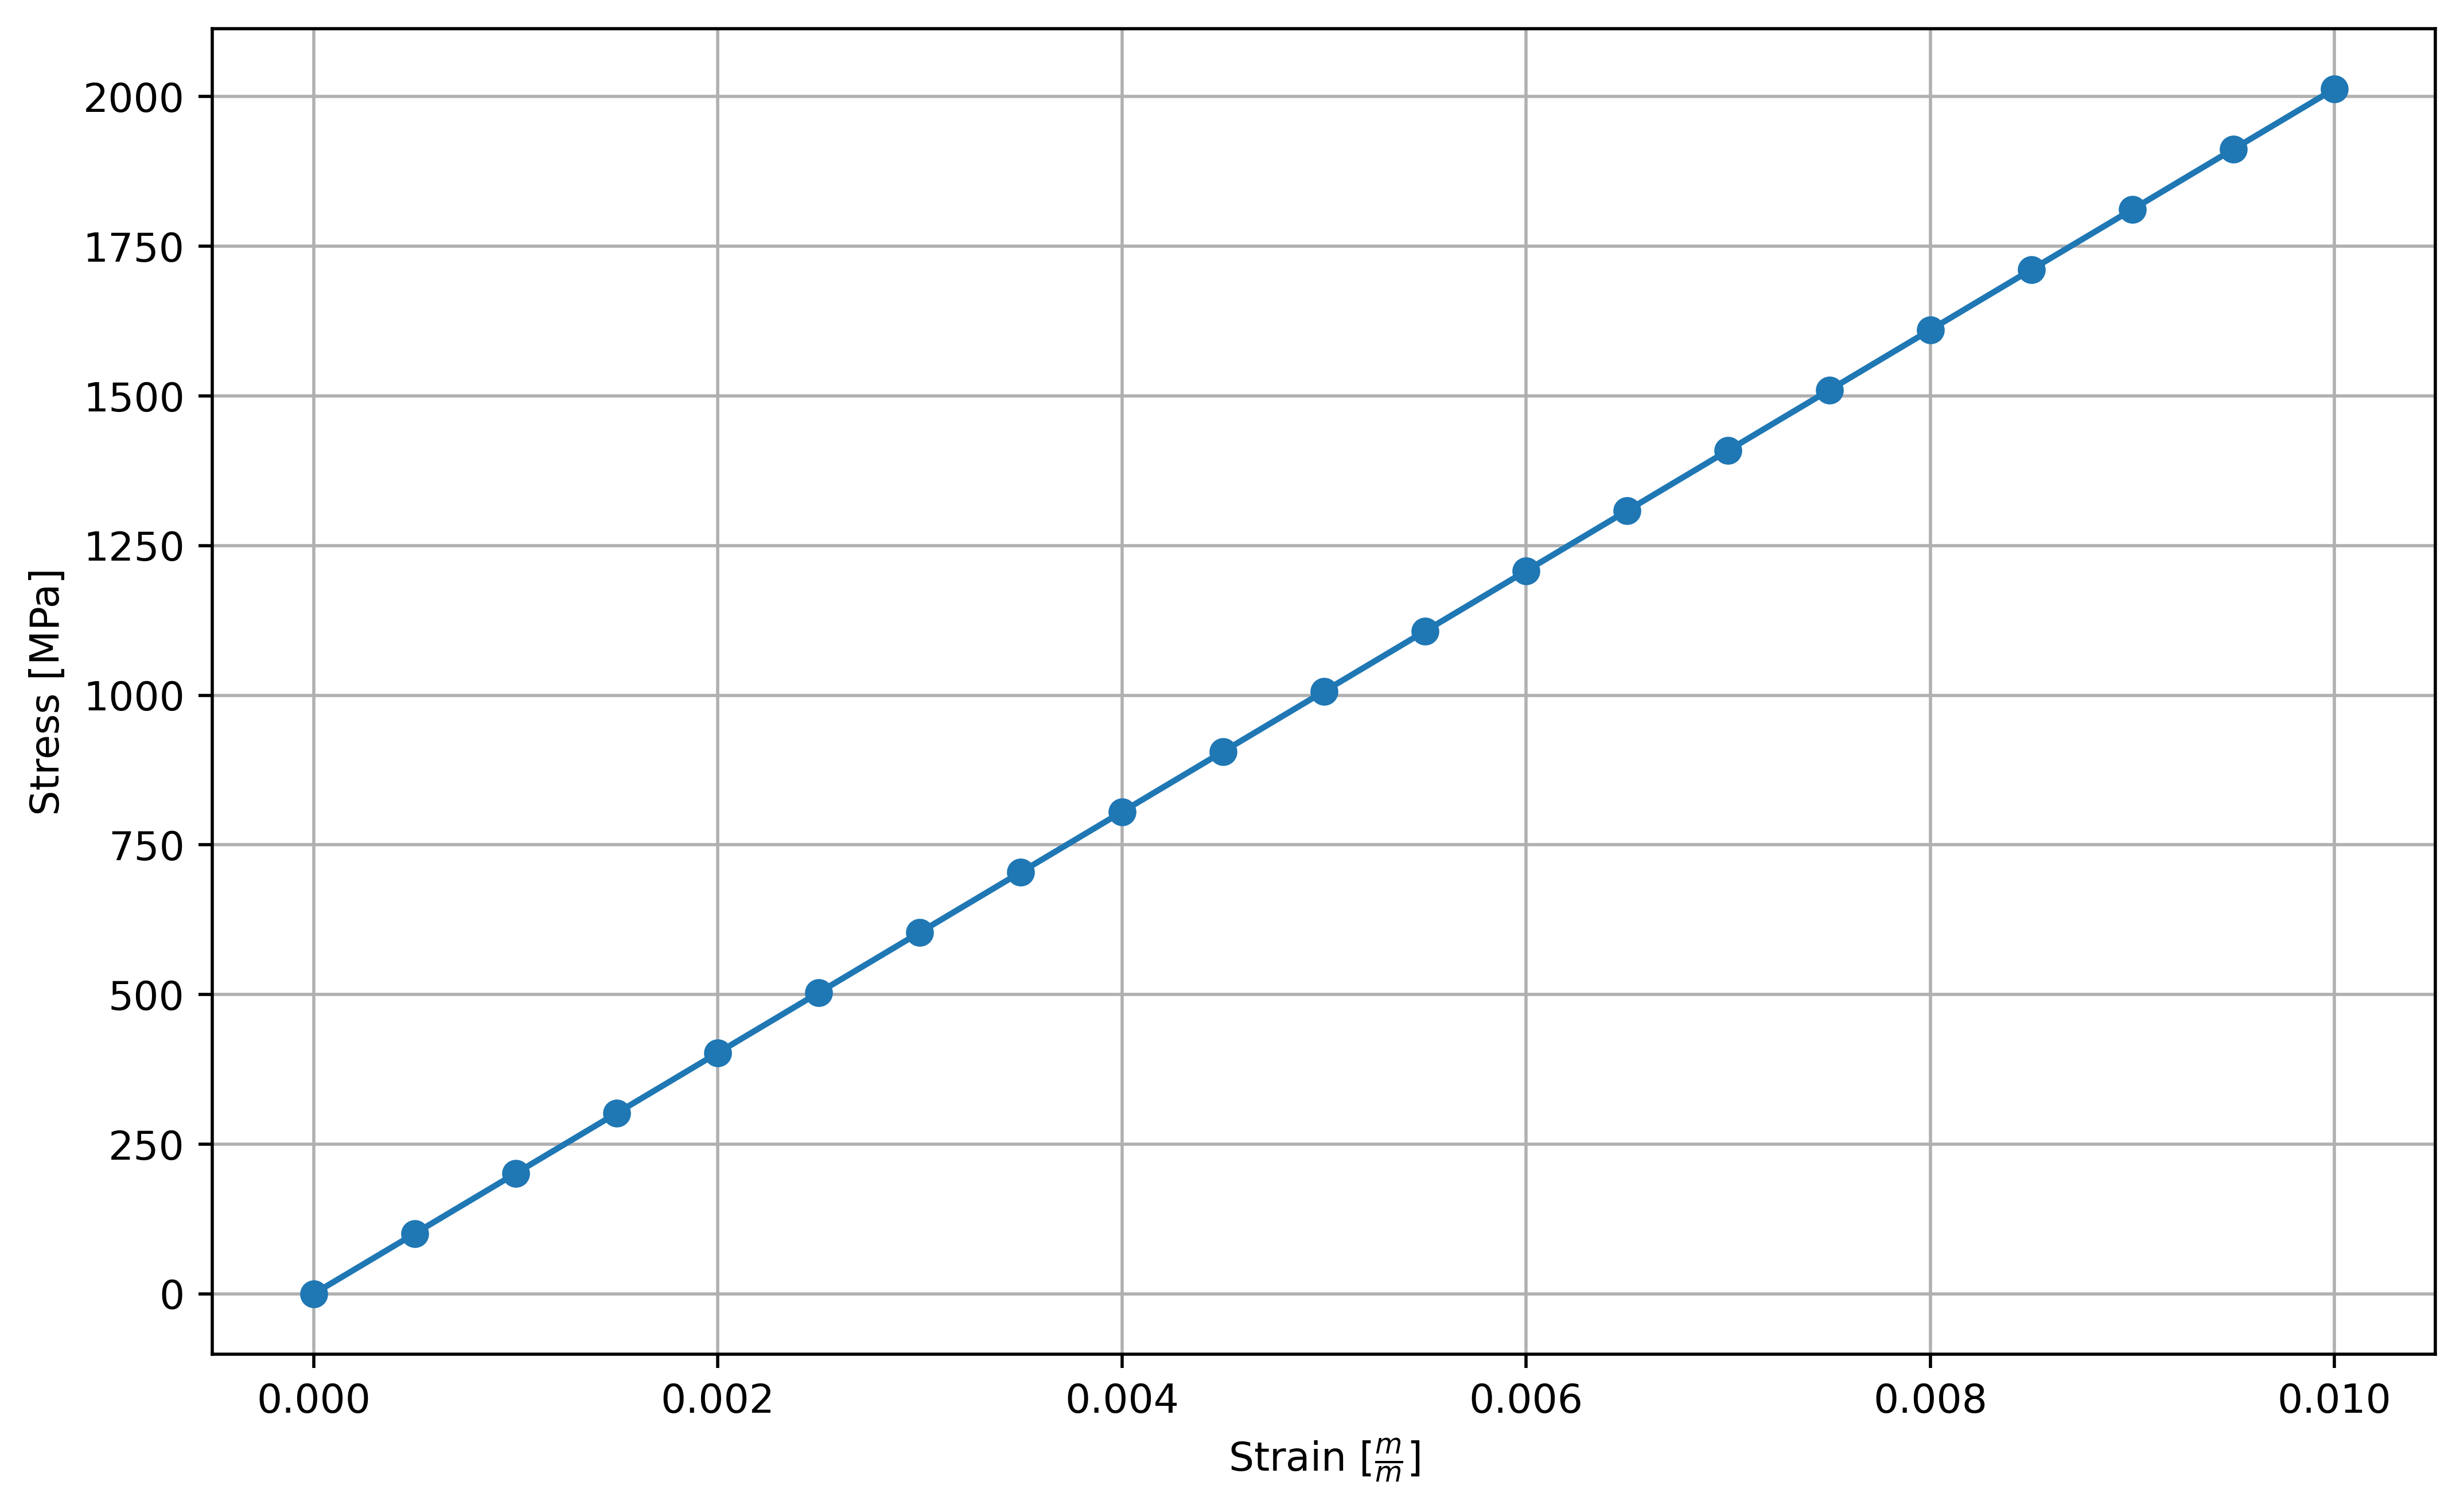

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6),dpi=500)
plt.plot(results[:, 0]/geom["longside"], results[:, 1], "-o")
plt.xlabel(r"Strain [$\frac{m}{m}$]")
plt.ylabel(r"Stress [MPa]")
plt.grid()
plt.show()

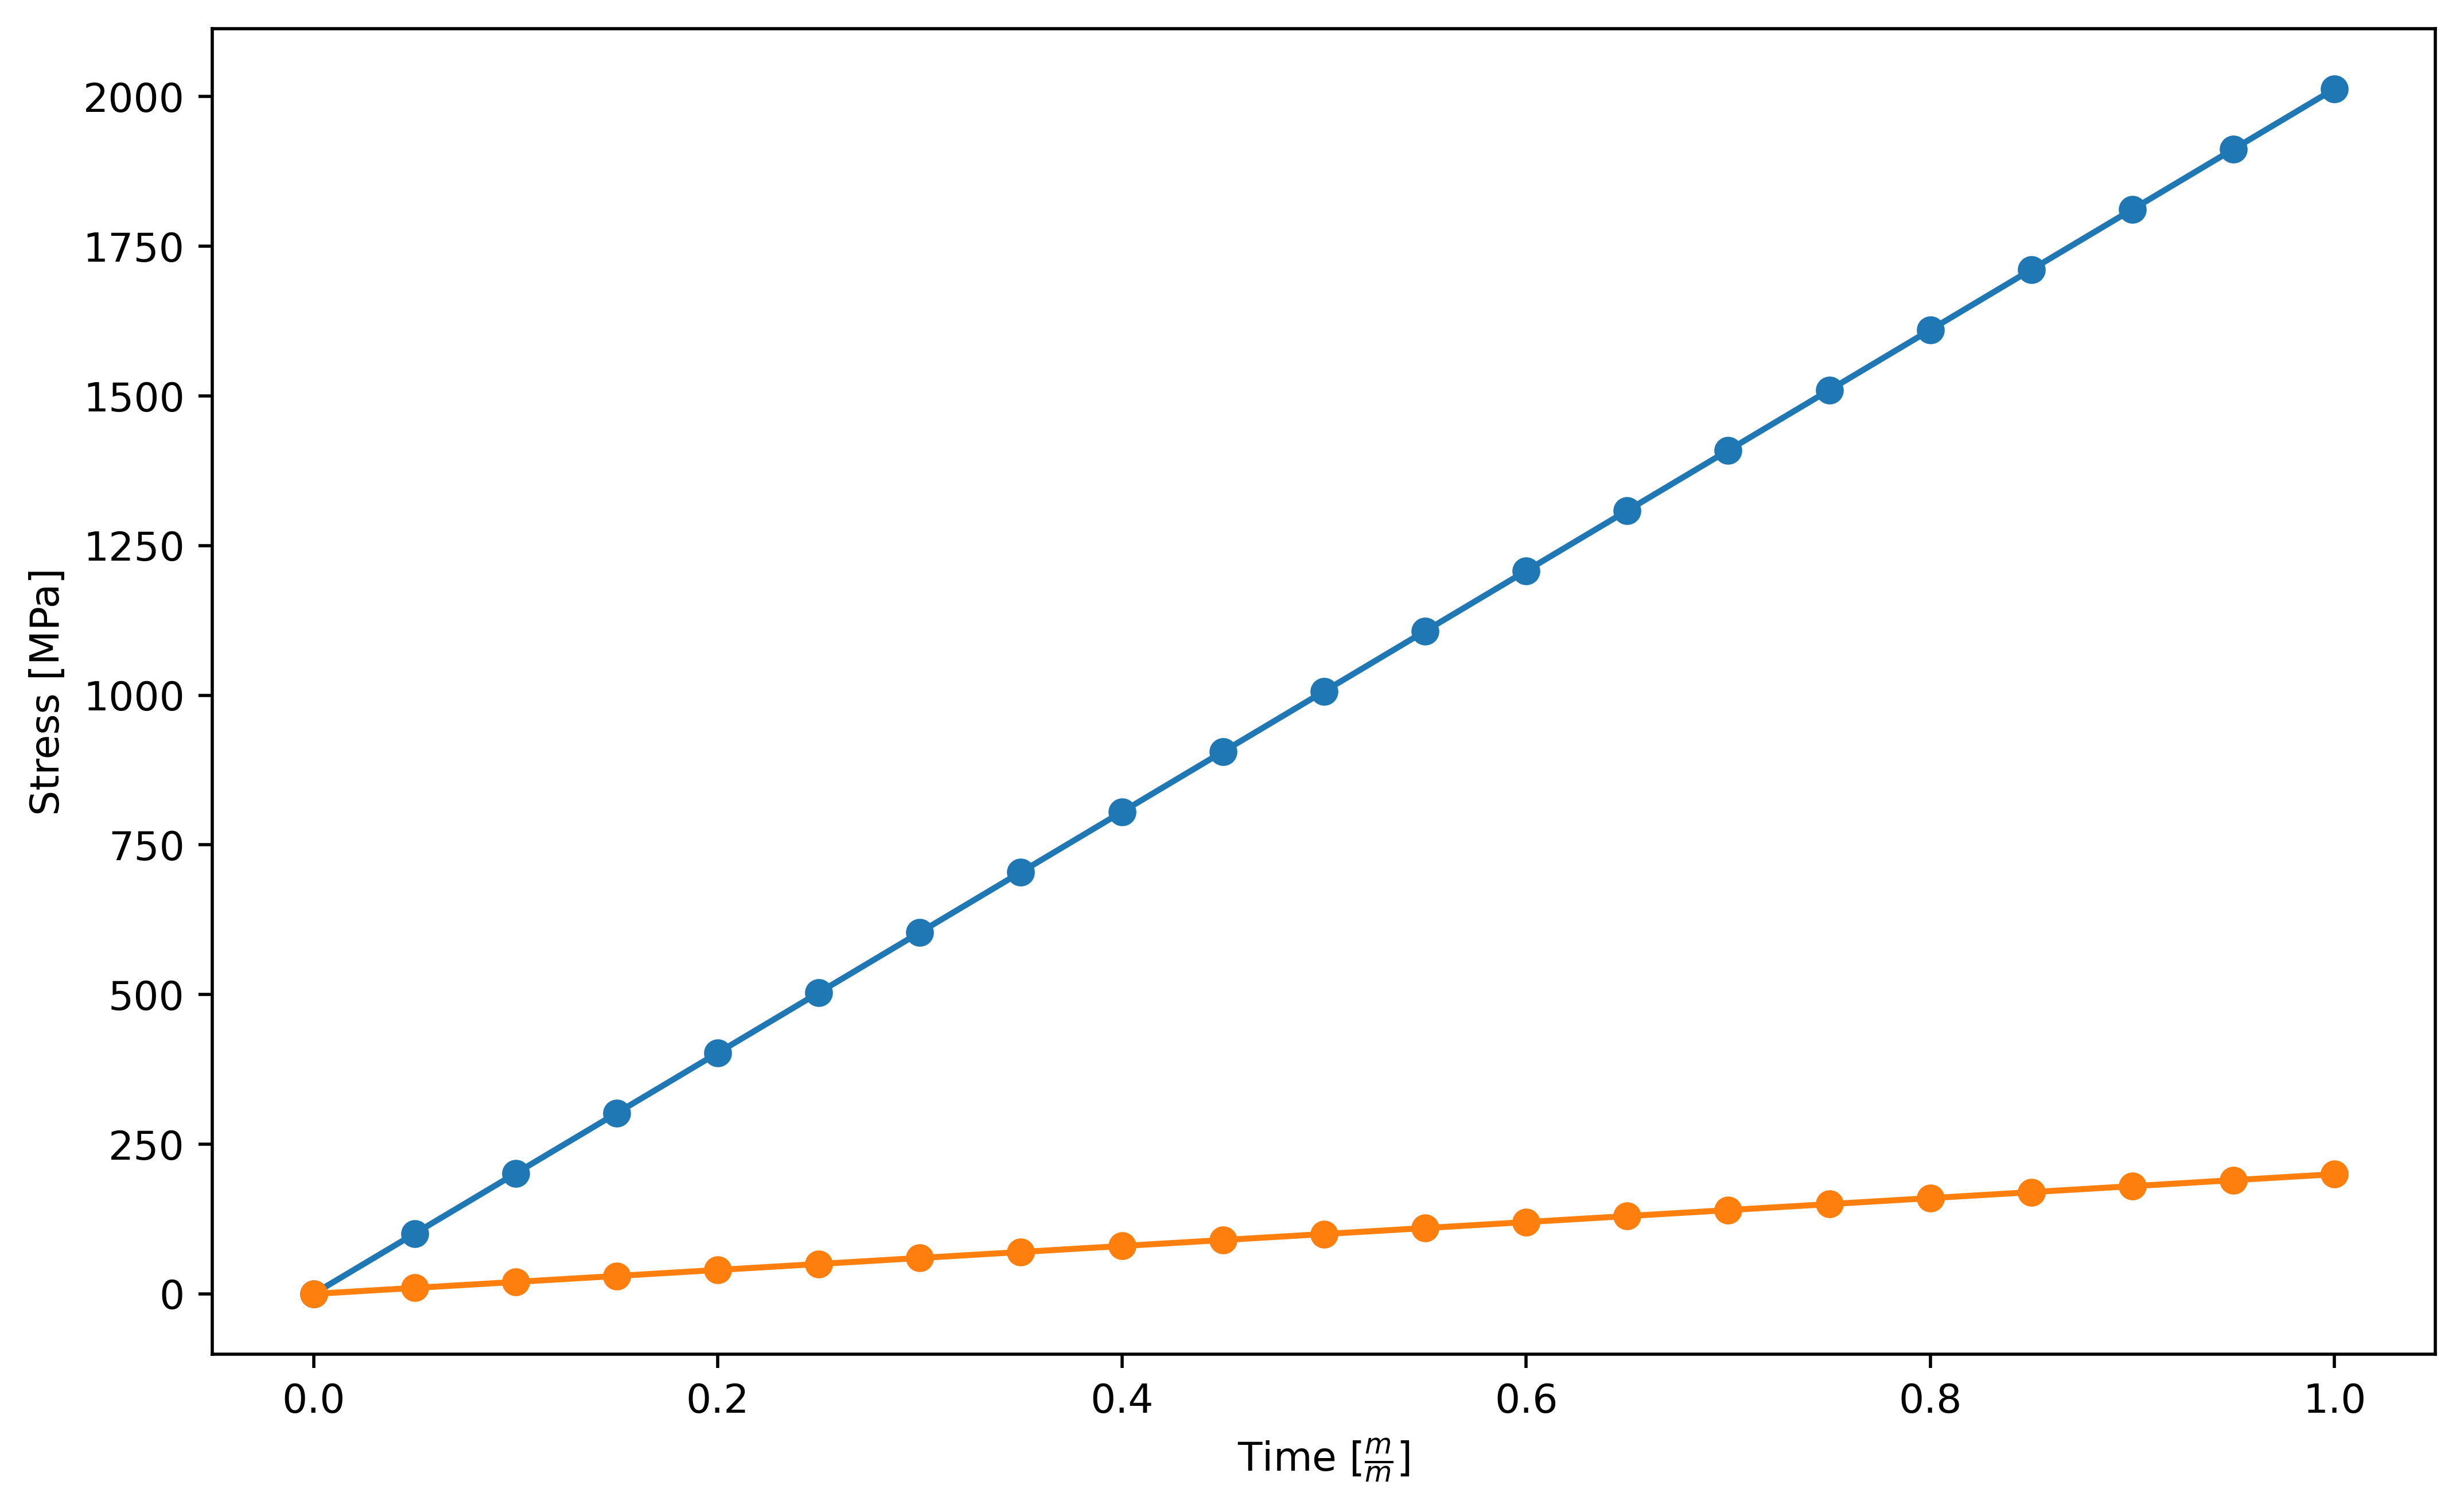

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6),dpi=500)
plt.plot(results[:, 2],results[:, 1], "-o")
plt.xlabel(r"Time [$\frac{m}{m}$]")
plt.ylabel(r"Stress [MPa]")
plt.grid()


plt.plot(results[:, 2],200*results[:, 2], "-o")
plt.xlabel(r"Time [$\frac{m}{m}$]")
plt.ylabel(r"Stress [MPa]")
plt.grid()
plt.show()

In [ ]:
results[-1,1]

2012.891898963506